This notebook contains an example of how to use the code.

In [1]:
from jacho.layers.reservoirs import RandomReservoir
from jacho.models.generic import GenericEchoState
from jacho.layers.output import Residual
from jacho.training.training import ridge
from jacho.data.KS import KS

from jax import random
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [2]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 2000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

np.random.seed(1)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()

In [3]:
# Prepping train and test matrices
# inputs need to be size [time_steps, samples, spatial_points]
# i.e. here they are [10000, 1, 100]
u = np.expand_dims(dns.uu, axis=1)
_, u_train, u_test, _ = np.split(u / np.sqrt(N), 
                                     [N_init, 
                                     (N_init + N_train), 
                                     (N_init + N_train + N_test)], axis=0)

In [4]:
# Setting up model
n_reservoir = 10000
reservoir_args = (0.4, 0.9, 0.1) #input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, RandomReservoir, reservoir_args,
                  n_out, Residual, output_layer_args)


key = random.PRNGKey(42)
state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [5]:
%%time
# Running the reservoir using method = model.run_reservoir
# Returns a (final_state, intermediate_states) tuple
new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

CPU times: user 5.46 s, sys: 4.7 s, total: 10.2 s
Wall time: 10.1 s


In [6]:
%%time
# Predicting with random output layer
# Running model.apply without specifying the method actually predicts
# and returns a tuple (final_state, prediction)

n_predict_steps = 100
new_state, prediction = model.apply(params, state, u_train[0], n_predict_steps)

CPU times: user 171 ms, sys: 659 µs, total: 171 ms
Wall time: 180 ms


In [7]:
%%time
# Training; we give the model, state and params
# It runs the reservoir and returns the state after running training and the updated params
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

CPU times: user 10 s, sys: 4.79 s, total: 14.8 s
Wall time: 15.6 s


In [8]:
%%time
# Extrapolate
# We start with the point after training and recursively predict
n_predict_steps = 2000
end_of_predict_state, prediction = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

CPU times: user 1.27 s, sys: 867 ms, total: 2.13 s
Wall time: 2.14 s


In [9]:
# Parsing; just removing unnecessary axes
truth  = u_test.squeeze()
prediction = prediction.squeeze()

Text(0.5, 0, 'x')

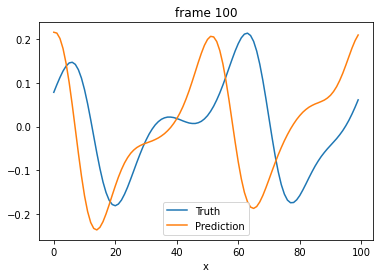

In [10]:
frame = 100
plt.plot(truth[frame], label='Truth')
plt.plot(prediction[frame], label='Prediction')
plt.title(f'frame {frame}')
plt.legend()
plt.xlabel('x')